# Workshop in  Data Science - Final Project

### Submitted by: Gil Or, Liel Shuker and Kobi Mizrahi

In this project we implemented a solution for a tabular data prediction task.
The project includes 5 stages: 

1. EDA 
2. Data Cleaning and Feature Engeeniring
3. Model Training, Prediction and Evaluation 
4. Model Investigation and Error Analysis
5. Conclusions Implementation

Our data is the Airbnb Price Prediction dataset from Kaggle - https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction.
There are no details attached to the data and the accumulation process. The data includes details about Airbnb properties including a log price cloumn we assume, by looking at some examples, refers to USD price per night. We will try to predict the log price column.

This project was written with awareness to the existence of public notebooks handling this data. We reviewed the existing solutions and tried to differentiate our solution. Our new approaches include handling the image column, error analysis and implementation of the analysis results and more.

### 0.1 Import Python Libraries


In [100]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xg
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from utils import *
import shap
import textstat
import nltk
import spacy

### 0.2 Uploading the Dataset


In [101]:
data = pd.read_csv('dataset/train.csv')
# while working we accidently encountered rows with price 0.
data = data[data['log_price'] != 0]

## 1. EDA

First of all, we would like to denote that in order to keep this notebook consice, we chose to present some selected points of the EDA process. While working on the project we did a more extensive exploration process.

In [102]:
data.shape

(74110, 29)

In [103]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,""Indoor fireplace"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials}",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9c86-41ea-a735-43d933111063.jpg?aki_policy=small,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Elevator in building"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo}",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [104]:
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

Our data consists of numerical values, categorial values, boolean values, strings, dates and images (by url link).

We will drop columns that we believe will not be helpful for the model

In [105]:
columns_to_drop = ['zipcode', 'id', 'name']

### **Data Types:**

In [106]:
data.dtypes

id                        int64  
log_price                 float64
property_type             object 
room_type                 object 
amenities                 object 
accommodates              int64  
bathrooms                 float64
bed_type                  object 
cancellation_policy       object 
cleaning_fee              bool   
city                      object 
description               object 
first_review              object 
host_has_profile_pic      object 
host_identity_verified    object 
host_response_rate        object 
host_since                object 
instant_bookable          object 
last_review               object 
latitude                  float64
longitude                 float64
name                      object 
neighbourhood             object 
number_of_reviews         int64  
review_scores_rating      float64
thumbnail_url             object 
zipcode                   object 
bedrooms                  float64
beds                      float64
dtype: object

Get to know the object type data values

In [107]:
pd.set_option('display.max_colwidth', 0)
data[['property_type','room_type','bed_type','cancellation_policy',
      'city','first_review','host_has_profile_pic','host_identity_verified',
     'host_response_rate','host_since','instant_bookable','last_review','neighbourhood']].agg(['unique']).transpose()

,unique
property_type,"[Apartment, House, Condominium, Loft, Townhouse, Hostel, Guest suite, Bed & Breakfast, Bungalow, Guesthouse, Dorm, Other, Camper/RV, Villa, Boutique hotel, Timeshare, In-law, Boat, Serviced apartment, Castle, Cabin, Treehouse, Tipi, Vacation home, Tent, Hut, Casa particular, Chalet, Yurt, Earth House, Parking Space, Train, Cave, Lighthouse, Island]"
room_type,"[Entire home/apt, Private room, Shared room]"
bed_type,"[Real Bed, Futon, Pull-out Sofa, Couch, Airbed]"
cancellation_policy,"[strict, moderate, flexible, super_strict_30, super_strict_60]"
city,"[NYC, SF, DC, LA, Chicago, Boston]"
first_review,"[2016-06-18, 2017-08-05, 2017-04-30, nan, 2015-05-12, 2017-08-27, 2017-03-10, 2016-12-16, 2016-02-13, 2017-04-03, 2013-04-28, 2015-07-02, 2017-02-18, 2017-03-25, 2016-08-14, 2016-07-16, 2015-09-26, 2017-07-30, 2016-06-26, 2015-10-10, 2016-07-23, 2014-10-20, 2016-07-17, 2017-07-03, 2015-12-30, 2016-03-20, 2017-01-01, 2011-11-26, 2011-05-20, 2017-03-18, 2017-07-07, 2014-03-24, 2017-07-24, 2014-01-03, 2015-08-12, 2016-06-20, 2017-03-15, 2016-11-14, 2017-08-30, 2017-03-26, 2014-03-19, 2015-07-06, 2016-10-11, 2015-06-08, 2015-12-23, 2015-10-01, 2016-04-30, 2017-09-14, 2017-05-01, 2015-09-27, 2017-01-10, 2016-10-09, 2014-12-27, 2013-03-31, 2017-02-12, 2015-05-19, 2015-02-15, 2016-05-19, 2017-09-01, 2016-10-10, 2016-12-27, 2017-02-25, 2016-01-05, 2016-09-18, 2017-04-04, 2015-11-23, 2016-07-04, 2014-08-08, 2017-01-04, 2015-08-13, 2015-08-24, 2015-08-30, 2017-05-19, 2016-04-24, 2015-05-04, 2013-08-09, 2016-06-10, 2016-04-23, 2013-09-11, 2016-03-16, 2017-08-23, 2017-03-28, 2016-05-05, 2017-06-29, 2016-02-15, 2016-08-09, 2013-09-02, 2012-04-28, 2014-04-01, 2016-06-22, 2016-09-06, 2017-01-22, 2016-06-27, 2016-02-20, 2017-03-06, 2015-11-02, 2017-06-16, 2017-05-21, 2017-09-22, 2015-12-10, ...]"
host_has_profile_pic,"[t, nan, f]"
host_identity_verified,"[t, f, nan]"
host_response_rate,"[nan, 100%, 71%, 68%, 67%, 83%, 50%, 90%, 86%, 92%, 82%, 80%, 89%, 93%, 99%, 0%, 88%, 96%, 70%, 94%, 91%, 25%, 95%, 98%, 62%, 29%, 33%, 81%, 63%, 38%, 60%, 79%, 78%, 75%, 65%, 97%, 87%, 40%, 54%, 53%, 58%, 76%, 30%, 64%, 17%, 20%, 77%, 73%, 41%, 59%, 57%, 85%, 56%, 42%, 44%, 35%, 14%, 74%, 27%, 10%, 84%, 6%, 72%, 36%, 55%, 43%, 13%, 39%, 46%, 26%, 61%, 52%, 23%, 22%, 69%, 66%, 15%, 11%, 31%, 21%, 47%]"
host_since,"[2012-03-26, 2017-06-19, 2016-10-25, 2015-04-19, 2015-03-01, 2017-06-07, 2017-03-03, 2013-05-18, 2015-06-04, 2017-03-12, 2013-03-27, 2015-06-11, 2016-05-10, 2012-10-12, 2012-11-20, 2012-09-10, 2016-07-29, 2014-07-27, 2015-08-17, 2017-05-09, 2016-01-11, 2014-08-27, 2014-11-28, 2012-07-12, 2015-05-19, 2017-01-10, 2013-06-20, 2016-05-25, 2015-09-26, 2016-03-06, 2014-01-06, 2017-03-18, 2011-10-07, 2011-04-01, 2016-10-24, 2012-08-07, 2013-12-26, 2013-11-19, 2011-01-06, 2013-06-16, 2016-07-17, 2016-09-17, 2015-07-13, 2014-08-24, 2017-02-13, 2015-05-13, 2014-11-06, 2013-12-08, 2013-08-13, 2016-02-18, 2014-02-27, 2015-09-23, 2012-04-18, 2013-07-29, 2012-08-08, 2015-05-12, 2013-03-02, 2013-06-17, 2013-04-18, 2016-06-06, 2015-01-25, 2015-05-03, 2014-09-08, 2015-08-29, 2014-04-06, 2014-08-11, 2017-09-22, 2016-11-27, 2014-12-06, 2014-03-10, 2014-10-17, 2016-01-20, 2010-03-13, 2014-12-19, 2016-05-02, 2013-03-07, 2014-03-22, 2013-11-29, 2015-03-26, 2015-07-21, 2012-08-09, 2012-03-08, 2014-08-21, 2012-07-31, 2013-11-12, 2016-06-29, 2012-05-18, 2017-01-05, 2013-11-05, 2015-10-12, 2015-07-28, 2015-03-15, nan, 2015-01-22, 2012-04-12, 2017-01-03, 2014-11-25, 2012-04-25, 2014-04-14, 2015-03-14, ...]"


In [108]:
print("Number of unique amenities values: " + str(len(data['amenities'].unique())))

Number of unique amenities values: 67121


We now understand that some of the object type columns will require specific treatment. For example, conversion to boolean and float, reduction in the number of categories, handling dates etc. 


In [109]:
binary_variables = ['host_has_profile_pic','host_identity_verified','instant_bookable','cleaning_fee']

numeric_variables = ['accommodates','beds','bedrooms','bathrooms','host_response_rate','latitude','longitude',
                     'number_of_reviews','review_scores_rating']

categorical_variables = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood']

dates_variables = ['host_since','first_review','last_review']

# amenities and thumbnail_url are not included since they require special treatment that will be implemented
# throughout the document.

### **Columns with Null Values and their Count:**

In [110]:
data[data.columns[data.isnull().any()]].isnull().sum()

bathrooms                 200  
first_review              15864
host_has_profile_pic      188  
host_identity_verified    188  
host_response_rate        18299
host_since                188  
last_review               15827
neighbourhood             6872 
review_scores_rating      16722
thumbnail_url             8216 
zipcode                   966  
bedrooms                  91   
beds                      131  
dtype: int64

In [111]:
data[['accommodates','bathrooms','beds', 'bedrooms']].corr()

,accommodates,bathrooms,beds,bedrooms
accommodates,1.000000,0.505631,0.810800,0.709259
bathrooms,0.505631,1.000000,0.525590,0.589935
beds,0.810800,0.525590,1.000000,0.709415
bedrooms,0.709259,0.589935,0.709415,1.000000


Since 'accommodates', 'beds' and 'bedrooms' have high correlation and 'accommodates' has no null values, we will drop 'beds' and 'bedrooms'.

In [112]:
columns_to_drop.extend(['beds', 'bedrooms'])
numeric_variables.remove('beds')
numeric_variables.remove('bedrooms')

### **Data Distributions**

 **host_has_profile_pic column ditribution:**

In [113]:
data['host_has_profile_pic'].value_counts()

t    73696
f    226  
Name: host_has_profile_pic, dtype: int64

Since less than 1% of the 'host_has_profile_pic' column has False value, we will drop it.

In [114]:
columns_to_drop.append('host_has_profile_pic')
binary_variables.remove('host_has_profile_pic')

**Log price target column distribution:**

<AxesSubplot:xlabel='log_price', ylabel='Density'>

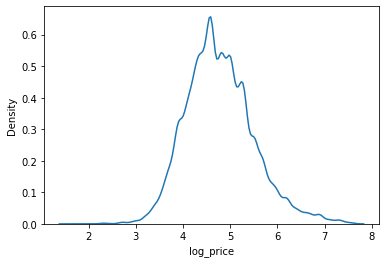

In [115]:
sns.kdeplot(data['log_price'])

**Categorical varaiables distribution**

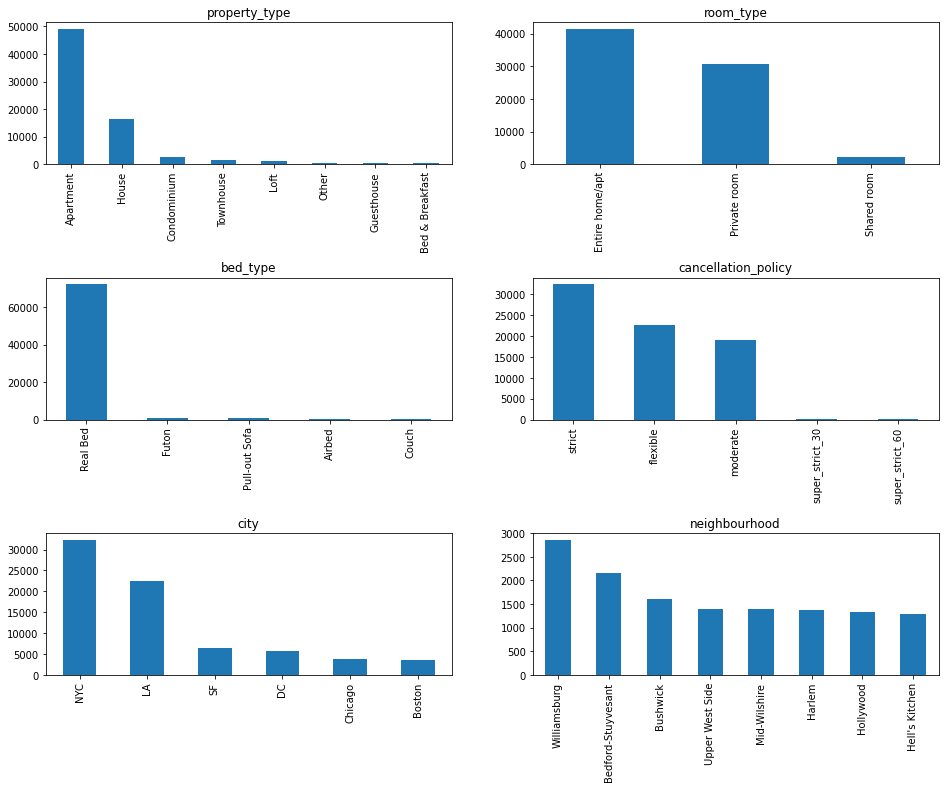

In [116]:
fig, axes = plt.subplots(3,2,figsize=(16,12))
fig.subplots_adjust(hspace=0.8)

#we will create a histogram for each categorical attribute
n=len(categorical_variables)
num_rows = 2
max_bars = 8

for i,variable in enumerate(categorical_variables):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(data[variable].nunique(),max_bars)
    vc = data[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

We notice that there are no prominent 'neighbourhoods', we would like to check number of unique values:

In [117]:
len(data['neighbourhood'].unique())

620

There are too many 'neighbourhoods' with no prominent ones. Since we also have 'longitude' and 'latitude' - we will drop 'neighbourhood' column.

In [118]:
columns_to_drop.append('neighbourhood')
categorical_variables.remove('neighbourhood')

**Date columns distribution**

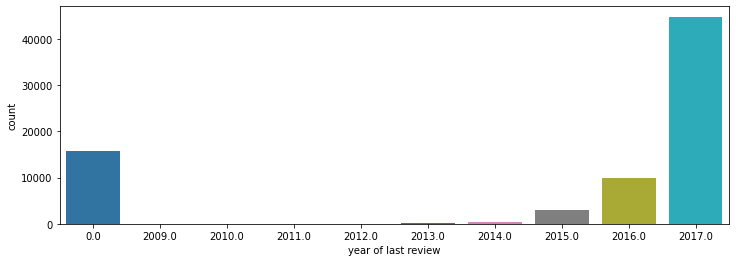

In [119]:
years_of_last_review = pd.DataFrame({
    'year of last review':pd.to_datetime(data['last_review'], format='%Y-%m-%d', errors='coerce').dt.year.fillna(0)
})

plt.figure(figsize=(12,4))
sns.countplot(x="year of last review", data=years_of_last_review)
plt.show()

### **Correlations Plots**

Text(0.5, 1.0, 'Log Price Distribution Per Accommodates Value\n')

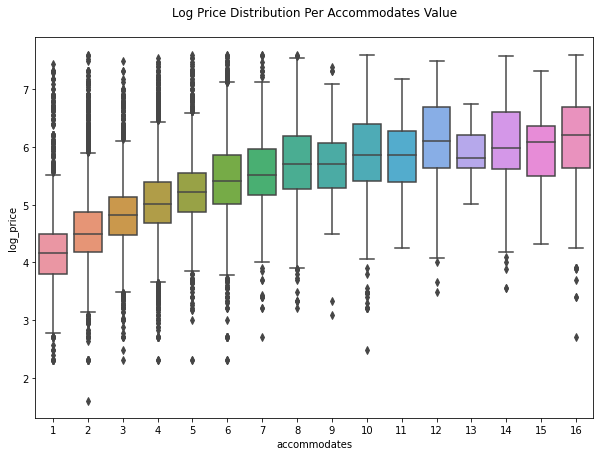

In [120]:
fig = plt.figure(figsize = (10,7))
sns.boxplot(x=data['accommodates'], y=data['log_price'])
plt.title('Log Price Distribution Per Accommodates Value\n')

We observe some positive correlation between the 'accommodates' value and the log price. We also observe that low 'accommodate' values hold more outliers.

Text(0.5, 1.0, 'Log Price Distribution Per City Value\n')

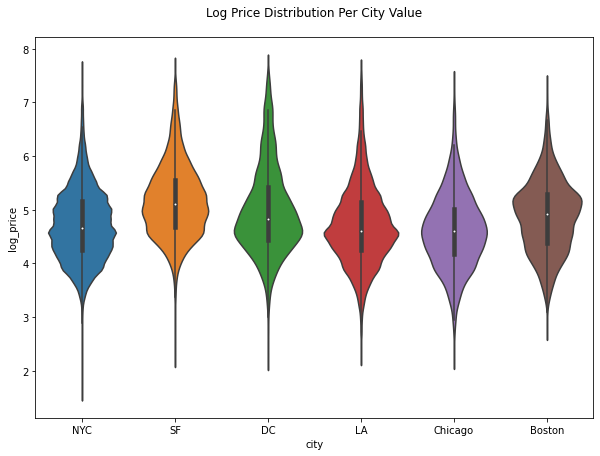

In [121]:
fig = plt.figure(figsize = (10,7))
sns.violinplot(x=data['city'], y=data['log_price'])
plt.title('Log Price Distribution Per City Value\n')

We observe that SF has higher prices in general. Most of Boston's properties also have higher prices. In addition NYC has more outliers.

Text(0.5, 1.0, 'Log Price Distribution Per Room Type Value\n')

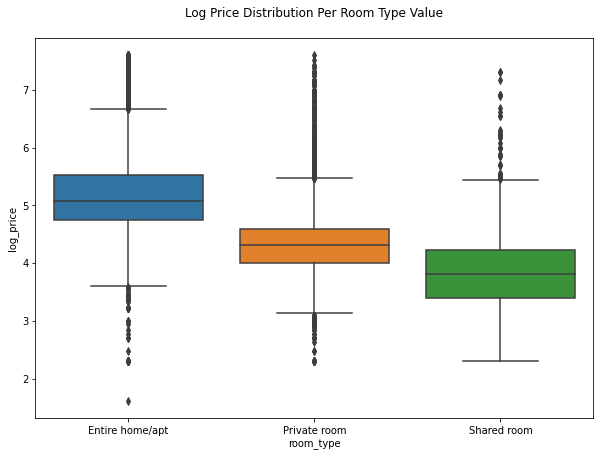

In [122]:
fig = plt.figure(figsize = (10,7))
sns.boxplot(x=data['room_type'], y=data['log_price'])
plt.title('Log Price Distribution Per Room Type Value\n')

We notice a prominent correlation between 'room type' and log price but with some outliers. Shared room has less outliers.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


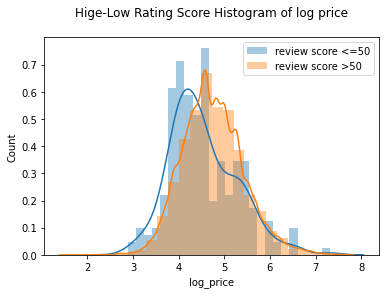

In [123]:
fig,ax=plt.subplots()

reviewScoreLow = data[data['review_scores_rating'] <= 50]
reviewScoreHigh = data[data['review_scores_rating'] > 50]

sns.distplot(reviewScoreLow.log_price, bins = 25, kde = True, label = "review score <=50",ax=ax)
sns.distplot(reviewScoreHigh.log_price, bins = 25, kde = True, label = "review score >50",ax=ax)


plt.title('Hige-Low Rating Score Histogram of log price\n')
plt.xlabel('log_price')
plt.ylabel('Count')
plt.legend(loc="upper right")

In general, we can say that properties with a high review score (above 50) have a higher price since the orange graph is higher for higher values of log_price on the x-axis

## 2. Data Cleaning and Feature Engeeniring 

#### This section includes: handling of special columns, dropping of unnecessary columns, handling of null values, one-hot encoding for categorial columns, type conversion and columns equalization.

### Handling thumbnail_url Column

We converted the 'thumbnail_url' column (which contained a link to the property's image) into two new columns we prepared in advance in a seperate code (attached in the submission folder):
1. brightness - a numeric value of the brightness of the image.
2. images_tags - we passed the images into an existing model that is based on InceptionV3 model - the model can be found in the link: https://github.com/moe18/Image-Based-Airbnb-Pricing-Algorithm.git. This model predicts a property price from its image. We add this predictions as a new feature instead of 'thumbnail_url'.

In [124]:
brightness = pd.read_csv('dataset/brightness.csv')['brightness']
data['brightness'] = brightness
data['brightness'] = data['brightness'].replace({'0': np.nan, 0: np.nan})

images_tags = pd.read_csv('dataset/price_by_model.csv')['price_by_model']
data['images_tags'] = images_tags
data['images_tags'] = data['images_tags'].replace({'0': np.nan, 0: np.nan})

In [125]:
columns_to_drop.append('thumbnail_url')
numeric_variables.extend(['brightness','images_tags'])

### Handling Dates Columns

We would like to convert the dates columns into numeric columns with a float that represent number of years until today's date.

In [128]:
data = convert_date_to_years_since(data, dates_variables)
numeric_variables.extend(dates_variables)
dates_variables = []

conversion result example:

In [129]:
data['last_review'][0]

6.082191780821918

### Handling host_response_rate


Right now the 'host_response_rate' column has the shape of 'n%'. We would like to convert it to floats between 0 to 1.

In [130]:
data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype('float') / 100.0

### Drop Unnecessary Columns

In [131]:
columns_to_drop

['zipcode',
 'id',
 'name',
 'beds',
 'bedrooms',
 'host_has_profile_pic',
 'neighbourhood',
 'thumbnail_url',
 'description']

In [132]:
for column in columns_to_drop:
    data = data.drop(column, axis=1)

### Train - Test Split

For the following operations, in order to prevent data leak from our test set, we would
like to split data into train and test and perform operations on both sets seperately.

In [133]:
train, test = train_test_split(data, test_size=0.2)
train = train.reset_index()
test = test.reset_index()

### Impute Missing Values


Find out which columns have null values:

In [134]:
train[train.columns[train.isnull().any()]].isnull().sum()

bathrooms                 160  
first_review              12636
host_identity_verified    153  
host_response_rate        14597
host_since                153  
last_review               12612
review_scores_rating      13321
brightness                6686 
images_tags               6723 
dtype: int64

For all the above columns (and test's null columns) we will impute missing values with the following logic: numerical values will be imputed with the mean value of their column and all other values will be imputed with most frequent. The code is detailed in the utils.py file attached in the submission repository.  

We would like to denote that we tried other methods as well. We tried to impute by mean, median, most frequenst, and zero value. We found the logic that we implemented to be the best way to deal with those None value.

In [135]:
train, test = impute_missing_values(train,test)

### Handling amenities Column

Right now the 'amenities' column is a string column where each string describes a list of amenities of the property. The Data has around 60,000 different unique values. 
We will read those strings, collect all the amenities and create a boolean column for the top 50 amenities in the train data. The code is detailed in the utils.py file attached in the submission repository.

In [136]:
train, test = convert_amenities_col(train, test, binary_variables)

### Types Conversion

In [137]:
for variable in categorical_variables:
    train[variable] = train[variable].astype("category")
    test[variable] = test[variable].astype("category")
    
for variable in numeric_variables:
    train[variable] = train[variable].astype(float)
    test[variable] = test[variable].astype(float)
    
for column in binary_variables:
    train[column] = train[column].apply(lambda x: 1 if x == 'TRUE' or x == 't' else 0)
    test[column] = test[column].apply(lambda x: 1 if x == 'TRUE' or x == 't' else 0)

In [138]:
train['brightness'].value_counts()

127.000000    6686
162.480067    11  
143.064493    7   
151.768101    7   
153.388503    6   
             ..   
124.168178    1   
107.410880    1   
140.870628    1   
128.475405    1   
97.044271     1   
Name: brightness, Length: 51695, dtype: int64

### One-Hot Encoding of Categorical_Variables

In [139]:
for variable in categorical_variables:
    onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
    train =  pd.concat([train, onehot_train_col], axis=1)
    train = train.drop(variable, axis=1)
    
    onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
    test =  pd.concat([test, onehot_test_col], axis=1)
    test = test.drop(variable, axis=1)

### Equalize Columns

In [140]:
add_to_test = list(set(train.columns) - set(test.columns))
add_to_train = list(set(test.columns) - set(train.columns))
for col in add_to_train:
    train[col] = 0
for col in add_to_test:
    test[col] = 0

test = test[train.columns]

In [141]:
train.shape

(59288, 125)

In [142]:
test.shape



(14822, 125)

## 3. Model Training, Prediction and Evaluation

We chose to use the XGBoost model since it is a state-of-the-art model for tabular data. In addition we tried some other models, linear regression, for example, and made sure we chose the best model for our data.

In [143]:
train_y = train['log_price'].values
train_x = train.drop('log_price', axis=1)

test_y = test['log_price'].values
test_x = test.drop('log_price', axis=1)

xgb_r = xg.XGBRegressor()

# Fitting the model
xgb_r.fit(train_x, train_y)
 
# Predict the model
prediction_test = xgb_r.predict(test_x)

# Evaluate the model
print("Model's Evaluation Mertics Results:\n")
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

Model's Evaluation Mertics Results:

Mean Absolute Error (Σ|y-pred|/n): 0.288
Mean Squared Error (Σ(|y-pred|/y)/n): 0.159
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.399
r2 score: 0.695


We would like to denote that we also tried to pedict log price price per 'acommodates' but it did not improve results.

## 4. Model Investigation and Error Analysis

### Residuals

We would like to display predictions in comparison to the real tags. We will do that on the following residuals graph.

Text(0, 0.5, 'Tags')

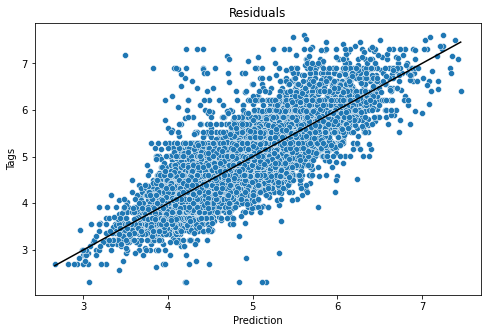

In [144]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=prediction_test,y=test_y,ax=ax)
sns.lineplot(x=prediction_test,y=prediction_test,ax=ax,color='black')
plt.title('Residuals')
plt.xlabel('Prediction')
plt.ylabel('Tags')

The closer a point is to the black line, the closer the prediction is to the real tag.   
The dots above the line represent under-estimated predictions.
The dots under the line represent over-estimated predictions.  
The residuals graph shows quite good results for the model.
We do observe some pattern of large residuals for the higher and lower tags.

The following graph will present the distribution of the residuals.

<AxesSubplot:xlabel='0', ylabel='Density'>

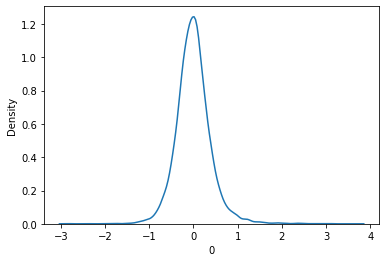

In [145]:
residuals = test_y - prediction_test
residuals_for_kde = pd.DataFrame(residuals)
sns.kdeplot(residuals_for_kde[0])

The residuals are normaly distributed around 0 as expected.

####  max over estimated and max under estimated predictions

In [146]:
max_over_estimated = abs(min(residuals))
max_under_estimated = max(residuals)
max_over_idx = list(residuals).index(min(residuals))
max_under_idx = list(residuals).index(max(residuals))
print("Max over estimated error (log price):", "{:,.0f}".format(max_over_estimated))
print("Max under estimated error (log price):", "{:,.0f}".format(max_under_estimated))

Max over estimated error (log price): 3
Max under estimated error (log price): 4


### Relative Residuals

Here we will examine each error with relation to its real tag:

In [147]:
rel_res=abs(residuals/test_y)
print(f'{int((len(rel_res[rel_res<0.05])/len(rel_res))*100)}% of the test set examples have error less than 5%')
print(f'{int((len(rel_res[rel_res<0.1])/len(rel_res))*100)}% of the test set examples have error less than 10%')
print(f'{int((len(rel_res[rel_res>0.2])/len(rel_res))*100)}% of the test set examples have error greater than 20%')


53% of the test set examples have error less than 5%
82% of the test set examples have error less than 10%
2% of the test set examples have error greater than 20%


### Actual Price Residuals

We predicted the log price, however when imagining a real-world application for this task, we can assume that the client would probably be interested in the actual price results.
We would like to analyse the predictions on the actual prices.

We will display the residuals graph after we applied the exponent operation on the real tags and on the predictions.

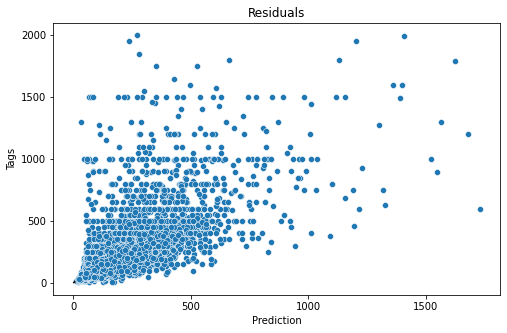

In [148]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=np.exp(prediction_test),y=np.exp(test_y),ax=ax)
sns.lineplot(x=prediction_test,y=prediction_test,ax=ax,color='black')
plt.title('Residuals')
plt.xlabel('Prediction')
plt.ylabel('Tags')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)

In this case the residuals graph looks weaker, especialy for the higher tags. 

We will dispaly the residuals ditribution as well:

<AxesSubplot:xlabel='0', ylabel='Density'>

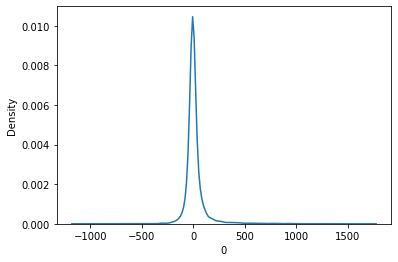

In [149]:
actual_res = np.exp(test_y) - np.exp(prediction_test)
actual_res_for_kde = pd.DataFrame(actual_res)
sns.kdeplot(actual_res_for_kde[0])

### Actual Price Relative Residuals

As we did for the log price, we will examine the relational error for the actual price:

In [150]:
act_rel_res = abs(actual_res/np.exp(test_y))
print(f'{int((len(act_rel_res[act_rel_res<0.05])/len(act_rel_res))*100)}% of the test set examples have error less than 5%')
print(f'{int((len(act_rel_res[act_rel_res<0.1])/len(act_rel_res))*100)}% of the test set examples have error less than 10%')
print(f'{int((len(act_rel_res[act_rel_res>0.2])/len(act_rel_res))*100)}% of the test set examples have error greater than 20%')

12% of the test set examples have error less than 5%
24% of the test set examples have error less than 10%
53% of the test set examples have error greater than 20%


We should be aware of the fact that the actual price prediction is worse.   
We should remember that relatively small error between log values may be greater when converting to actual price values.

###  SHAP Analysis of the Test Examples

We will use SHAP to learn feature importance and contribution values of the features for the different data points:

 99%|===================| 14651/14822 [00:45<00:00]        

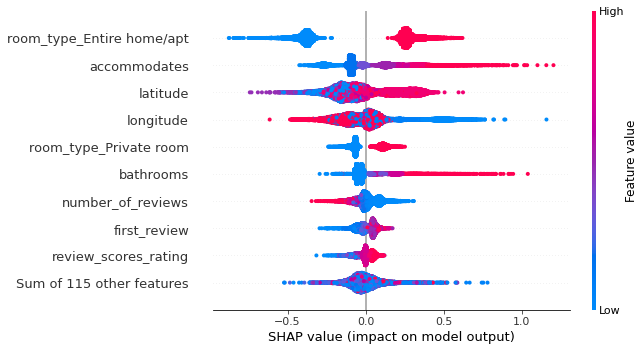

In [151]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_r, train_x)
shap_values = explainer(test_x)
shap.plots.beeswarm(shap_values)

We note two interesting points:  

First, we see that 'latitude' and 'longitude' have high shap importance scores. This makes sense but still we feel like this interpretability is not intuitive enough. We feel like high scores for high latitude values and low scores for high longitude valuse, as seen above, is too simplified. We would like to think of a better way to extract information from these features.  

Second, we see that 'number_of_reviews' is one of the more important features and it has negative correlation with the predicted price. It is quite unintuitive, since in the real world we assume that a property with many reviews would charge a higher price. If so, we can assert that this feature inserts noise into our data and therefore we will drop the feature. We must be careful with this assertion since the data can hold patterns that we will not pay attention to. For example, it may be that more expensive properties do not have many guests, therefore they do not have many reviews. Anyway, it will be interesting to test the model without this feature, we will test it later on in the notebook.  


It is interesting to check the correlation between the log_price column and 'number_of_reviews':

In [152]:
data[['log_price','number_of_reviews']].corr()

,log_price,number_of_reviews
log_price,1.000000,-0.032522
number_of_reviews,-0.032522,1.000000


The correlation is low, it supports the assumption that the 'number_of_reviews' column inserts noise into the data.

We will now display some dependence plots for some features and their SHAP values:

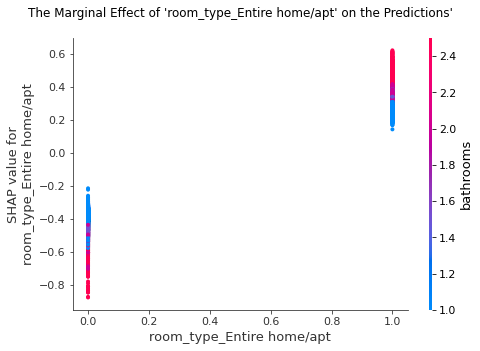

In [153]:
shap.dependence_plot('room_type_Entire home/apt', shap_values.values, test_x, show=False)
plt.title("The Marginal Effect of 'room_type_Entire home/apt' on the Predictions'\n")
plt.show()

We notice that data examples with 'room_type_Entire home/apt'=1 have a higher SHAP value for this specific feature.

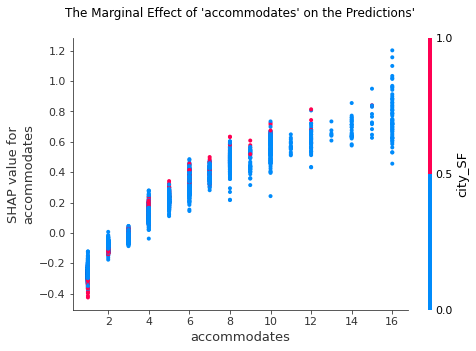

In [154]:
shap.dependence_plot('accommodates', shap_values.values, test_x, show=False)
plt.title("The Marginal Effect of 'accommodates' on the Predictions'\n")
plt.show()

In general, we see that the greater the 'accommodate' value, the greater its SHAP value.

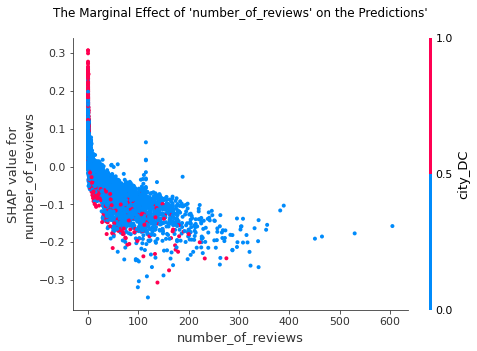

In [155]:
shap.dependence_plot('number_of_reviews', shap_values.values, test_x, show=False)
plt.title("The Marginal Effect of 'number_of_reviews' on the Predictions'\n")
plt.show()

We observe clear, logical behavior for the 'room_type_Entire home/apt' and 'accommodates' features. However the behavior of the 'number_of_reviews' feature is not clear.  
We see that for a small number of reviews we have a large range of shap values and as the number of reviews grow,  the shap value decreases. This is an interesting point for further research.

Next, we would like to split our data into two groups with similar properties.  
We will use shap cohorts:

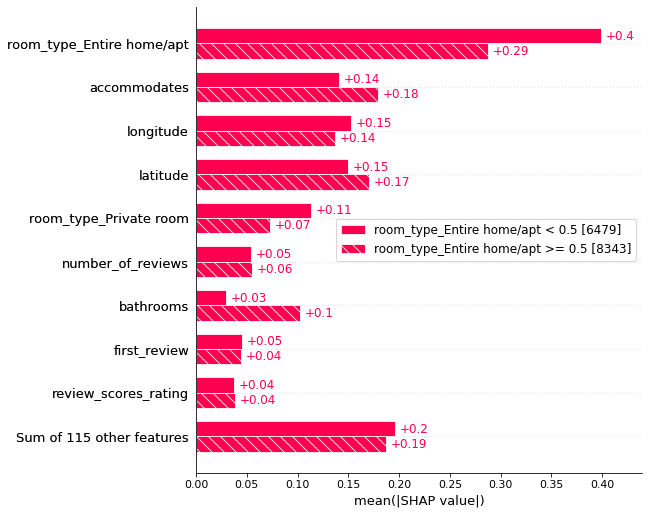

In [156]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

We observe that our test data can be split into two groups: properties with 'room type- entire room/apt' and properties without that feature. In most of the other features there is no major difference for the shap scores of the features. We do see some difference on the 'bathrooms' feature.

#### SHAP local investigation of some random examples:

In [157]:
shap.force_plot(explainer.expected_value, shap_values.values[0], test_x.iloc[0])

This example has a lower prediction than the base value. The main factors for the decrease of this prediction is 'room_type_Entire home/apt=0' and the 'latitude' value.

In [158]:
shap.force_plot(explainer.expected_value, shap_values.values[1], test_x.iloc[1])

This example has an average prediction value. The main factor for the decrease is 'room_type_Entire home/apt=0' and the main factor for the increase is the 'longitude' value.

### Over/Under Estimations

For the next few blocks we explore the over and under estimated examples.

In [159]:
# define rel_res again with no abs to get seperation between over and under estimates
rel_res=residuals/test_y

In [160]:
most_over_est_ind = np.where(rel_res==rel_res.min())[0][0]
print("Most Over Estimated Example:")
print("example's tag: " +str(test_y[most_over_est_ind]) + ", example's prediction: " + str(prediction_test[most_over_est_ind]))

Most Over Estimated Example:
example's tag: 2.302585092994046, example's prediction: 5.1601605


In [161]:
most_under_est_ind = np.where(rel_res==rel_res.max())[0][0]
print("Most Under Estimated Example:")
print("example's tag: " +str(test_y[most_under_est_ind])  + ", example's prediction: " + str(prediction_test[most_under_est_ind]))

Most Under Estimated Example:
example's tag: 7.170119543449628, example's prediction: 3.4931226


### SHAP analysis of the most over estimated example

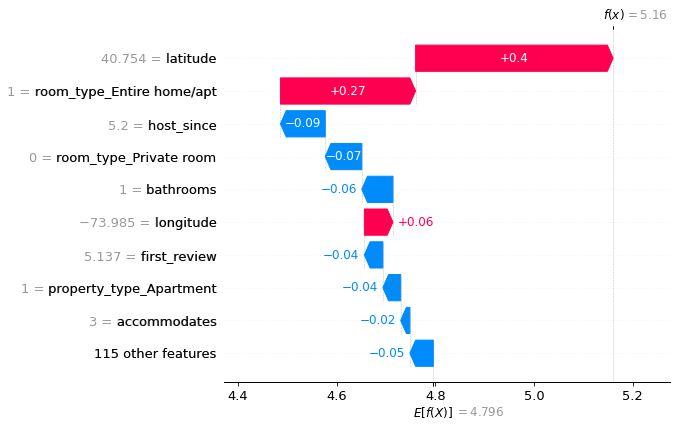

In [162]:
shap.plots.waterfall(shap_values[most_over_est_ind])

### SHAP analysis of the most under estimated example

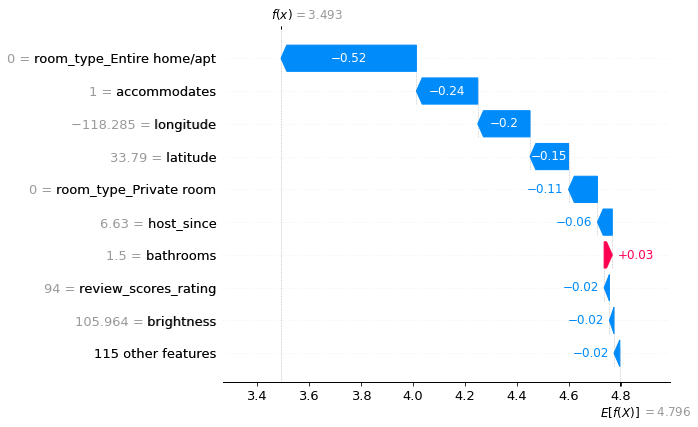

In [163]:
shap.plots.waterfall(shap_values[most_under_est_ind])

Define over/under/good estimates groups of examples:

In [164]:
over_estimates = test_x.loc[np.where(rel_res<-0.05)]
under_estimates = test_x.loc[np.where(rel_res>0.05)]
good_estimates = test_x.loc[np.where(abs(rel_res)<0.05)]

### SHAP analysis of under estimated examples

Feature importance and SHAP values for the under estimated group of examples:

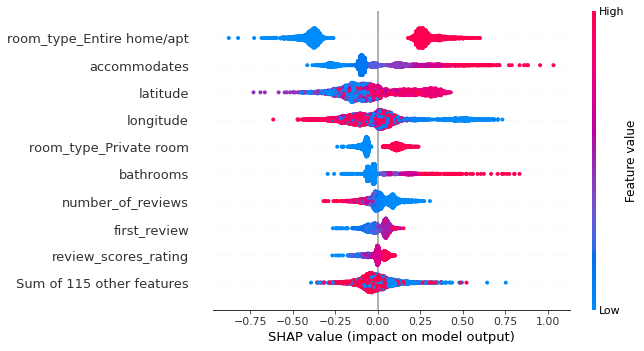

In [165]:
under_est_shap_values = explainer(under_estimates)
shap.plots.beeswarm(under_est_shap_values)

### Comparison of good and under estimated gropus features' distribution

Text(0.5, 1.0, 'room_type_Entire home/apt Distribution for Good and Under Estimations\n')

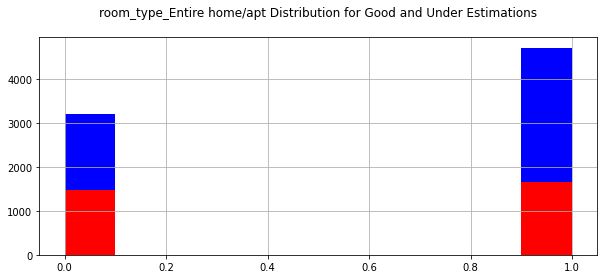

In [166]:
fig, ax = plt.subplots(figsize=(10,4))
good_estimates['room_type_Entire home/apt'].hist(ax=ax,color='blue')
under_estimates['room_type_Entire home/apt'].hist(ax=ax,color='red')
plt.title('room_type_Entire home/apt Distribution for Good and Under Estimations\n')

### SHAP analysis of over estimated examples

Feature importance and SHAP values for the under estimated group of examples:

 99%|===================| 3784/3807 [00:12<00:00]        

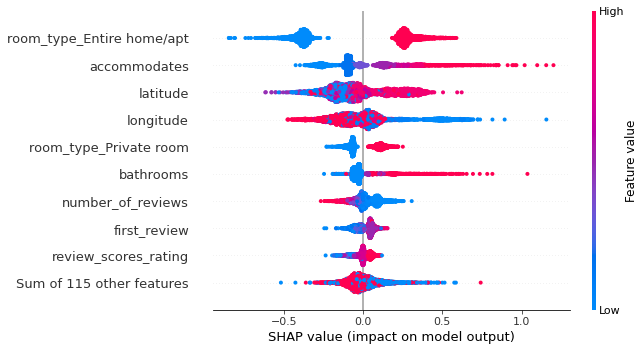

In [167]:
over_est_shap_values = explainer(over_estimates)
shap.plots.beeswarm(over_est_shap_values)

### Comparison of good and over estimated gropus distribution

Text(0.5, 1.0, 'longitude Distribution for Good and Over Estimations\n')

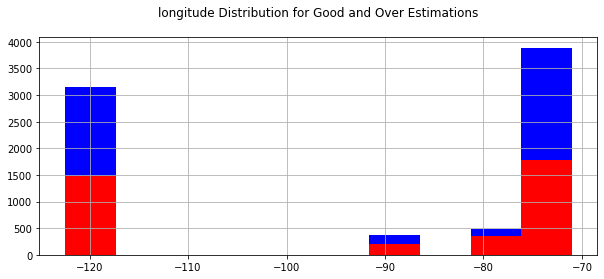

In [168]:
fig, ax = plt.subplots(figsize=(10,4))
good_estimates['longitude'].hist(ax=ax,color='blue')
over_estimates['longitude'].hist(ax=ax,color='red')
plt.title('longitude Distribution for Good and Over Estimations\n')

We compared many feature distributions (for under and over entimations) and all features had similar distributions with good estimations.

We did not find any patterns regarding under/over estimations.  
  
We did find a few examples where in the 'description' column we discovered that the offered price is for a month rather than a night. This can explain some of the under estimated examples. But, we also found many opposite examples, so we can not assert that this is a pattern.

It may be that because of any other decision that we took while proccessing the data, we did not extract all the information that we could have.    

At last, we should remember that the pricing proccess is manual and each property owner can put any price he wants. In addition, we assume that the data was taken from the Airbnb website where each property owner inserts the property's details by himself and can make mistakes. Therefore another possibilty is that the data is 'dirty'.

## 5. Conclusions Implementation

As a conclusion from the analysis section, we would like to try the following changes:
1. convert both longitude and latitude features to a more concise single neighbors' price feature using a KNN regressor.
2. drop the number_of_reviews feature.
3. predict the actual price.

### 1. Neighbors' Price Column with KNN Regressor

For each row in the data, we will convert both 'longitude' and 'latitude' columns into one column that will represent its k neighbors mean price that will be calculated by KNN rgressor.  
We belive this logic can distil the information embodied in the longitude latitude combination.

In [169]:
# prepare data for KNNregressor
train_x_knnr = train_x.copy()
test_x_knnr = test_x.copy()

data_knnr = pd.concat([train_x_knnr,test_x_knnr])
data_knnr = data_knnr[['latitude','longitude']]
target_knnr = pd.concat([pd.DataFrame(train_y),pd.DataFrame(test_y)])

In [170]:
# apply KNNregressor
from sklearn.neighbors import KNeighborsRegressor
knnr_model = KNeighborsRegressor(n_neighbors=100).fit(data_knnr, target_knnr)
preds = knnr_model.predict(data_knnr)

In [171]:
# combine new column with the original data for the original model
train_preds = preds[:59288]
test_preds = preds[59288:]

train_preds = pd.DataFrame(train_preds)
train_preds.columns=['neighbors_mean_price']
test_preds = pd.DataFrame(test_preds)
test_preds.columns=['neighbors_mean_price']

train_x_knnr = pd.concat([train_x_knnr,train_preds], axis=1)
test_x_knnr = pd.concat([test_x_knnr,test_preds], axis=1)

train_x_knnr = train_x_knnr.drop('longitude', axis=1)
train_x_knnr = train_x_knnr.drop('latitude', axis=1)
test_x_knnr = test_x_knnr.drop('longitude', axis=1)
test_x_knnr = test_x_knnr.drop('latitude', axis=1)

In [172]:
# run the model
xgb_r = xg.XGBRegressor()

xgb_r.fit(train_x_knnr, train_y)
 

prediction_test = xgb_r.predict(test_x_knnr)

print("Model's Evaluation Mertics Results:\n")
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

Model's Evaluation Mertics Results:

Mean Absolute Error (Σ|y-pred|/n): 0.288
Mean Squared Error (Σ(|y-pred|/y)/n): 0.158
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.398
r2 score: 0.697


SHAP explanation of the changed model:

 97%|=================== | 14438/14822 [00:42<00:01]       

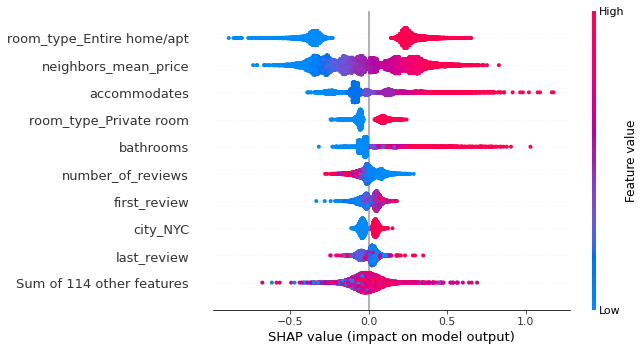

In [173]:
explainer = shap.TreeExplainer(xgb_r, train_x_knnr)
shap_values = explainer(test_x_knnr)
shap.plots.beeswarm(shap_values)

This addition improved the model's score only by a hundrenth of a point.  
But, no less important, it made the explainability of the model clearer and more intuitive.

### 2. Drop number_of_reviews feature

In [174]:
# use the data with the neighbors_mean_price addition
train_x = train_x_knnr
test_x = test_x_knnr

In [175]:
# drop number_of_reviews
train_x = train_x.drop('number_of_reviews', axis=1)
test_x = test_x.drop('number_of_reviews', axis=1)

In [176]:
# run the model
xgb_r = xg.XGBRegressor()

xgb_r.fit(train_x, train_y)
 

prediction_test = xgb_r.predict(test_x)

print("Model's Evaluation Mertics Results:\n")
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

Model's Evaluation Mertics Results:

Mean Absolute Error (Σ|y-pred|/n): 0.290
Mean Squared Error (Σ(|y-pred|/y)/n): 0.160
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.400
r2 score: 0.693


SHAP explanation of the changed model:

 98%|===================| 14453/14822 [00:40<00:01]        

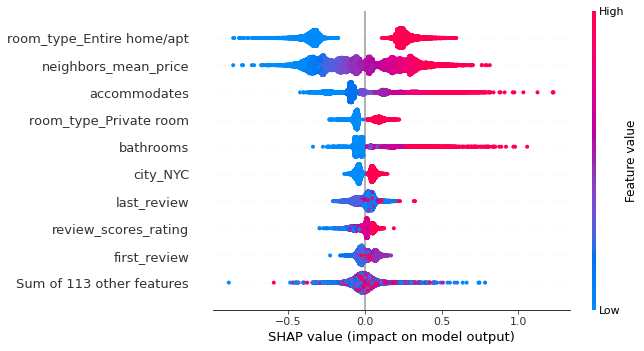

In [177]:
explainer = shap.TreeExplainer(xgb_r, train_x)
shap_values = explainer(test_x)
shap.plots.beeswarm(shap_values)

This addition did not make a significant change on the model's results but it made some changes on the model's explainabilty. Now 'first_review' and 'last_review' are prominent featuers, in the future we would want to explore them.

### 3. Predict actual price

In [178]:
# change target columns to actual price
train_y = np.exp(train_y)
test_y = np.exp(test_y)

In [179]:
# run the model
xgb_r = xg.XGBRegressor()

xgb_r.fit(train_x, train_y)
 

prediction_test = xgb_r.predict(test_x)

print("Model's Evaluation Mertics Results:\n")
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

Model's Evaluation Mertics Results:

Mean Absolute Error (Σ|y-pred|/n): 55.734
Mean Squared Error (Σ(|y-pred|/y)/n): 13,029.883
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 114.149
r2 score: 0.546


In [180]:
prediction_test

array([ 79.71501 , 129.83589 ,  78.95033 , ..., 229.69518 , 139.53044 ,
        96.488686], dtype=float32)

The residuals graph and the relative residuals score of the changed model:

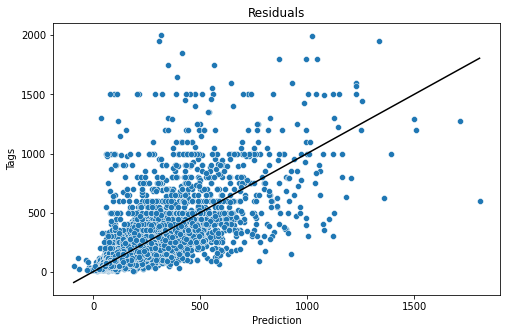

In [181]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=prediction_test,y=test_y,ax=ax)
sns.lineplot(x=prediction_test,y=prediction_test,ax=ax,color='black')
plt.title('Residuals')
plt.xlabel('Prediction')
plt.ylabel('Tags')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)

In [182]:
actual_res = test_y - prediction_test
act_rel_res = abs(actual_res/test_y)
print(f'{int((len(act_rel_res[act_rel_res<0.05])/len(act_rel_res))*100)}% of the test set examples have error less than 5%')
print(f'{int((len(act_rel_res[act_rel_res<0.1])/len(act_rel_res))*100)}% of the test set examples have error less than 10%')
print(f'{int((len(act_rel_res[act_rel_res>0.2])/len(act_rel_res))*100)}% of the test set examples have error greater than 20%')

10% of the test set examples have error less than 5%
21% of the test set examples have error less than 10%
58% of the test set examples have error greater than 20%


This addition did not improve the actual price comparison results.

## Future Ideas

If we were to continue working on this project, we would like to try:
1. Test further feature engineering options and explore model explainabilty. For example: change the k for the top k amenities, convert amenities to a single column that will represent number of amenities, reduce number of categories in the property type column by grouping the different types, etc.  


2. Since our handling of the image column did not significantly improve the model's results, we would like to try a totally different approach. We would like to apply image embedding and table embedding models to our data, concatenate both embeddings and insert them into a neural network as one component. This way the prediction will rely on both at once.  
